## LIBRARY

In [3]:
import os
import re
import pandas as pd
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import math
from collections import Counter

## READING FHIR

In [ ]:

directory = 'C:/Users/begon/synthea/output/deneme1'

pattern = re.compile(r'(\"resourceType\": \"(Patient|Encounter|Condition|Observation|Procedure|Medication)\")')

classes = ['Patient', 'Encounter', 'Condition', 'Observation', 'Procedure', 'Medication']

current_resource_type = None
new_resource_type = None
resource_type = None
current_id = None
new_id = None
current_references = []
current_codes = []
current_patient_id = None

data = {'ResourceType': [], 'ID': [], 'References': [], 'Codes': [], 'PatientID': []}

counts = {resource_type: 1 for resource_type in classes}

INIT = False

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            for line in f:
                match = pattern.search(line)
                if '"resourceType": "' in line and not match:
                    resource_type = line.split('"')[3]
                    INIT = False
                if match:
                    if match.group(2) in classes:
                        new_resource_type = match.group(2)
                        INIT = True
                        next_line = next(f, None)
                        if next_line and '"id": "' in next_line:
                            new_id = next_line.split('"id": "')[1].split('"')[0]
                if current_resource_type == new_resource_type and '"reference": "urn:uuid:' in line and INIT:
                    reference = line.split(':')[3].split('"')[0]
                    current_references.append(reference)      
                if current_resource_type == new_resource_type and '"code": "' in line and INIT:     
                    code = line.split('"code": "')[1].split('"')[0]
                    current_codes.append(code)
                if current_resource_type != new_resource_type  and INIT:
                    if current_resource_type and current_id:
                        data['ResourceType'].append(current_resource_type)
                        data['ID'].append(current_id)
                        if current_resource_type == 'Patient':
                            current_patient_id = current_id
                        data['References'].append(tuple(current_references))
                        data['Codes'].append(tuple(current_codes))
                        data['PatientID'].append(current_patient_id)
                        current_references = []
                        current_codes = []
                    current_resource_type = new_resource_type    
                    current_id = new_id

df = pd.DataFrame(data)
grouped = df.groupby('PatientID')
aggregated_data = grouped.sum()
aggregated_data.to_csv('C:/Users/begon/Desktop/LMI PROJECT/Patient1.csv')


## COMBINE FHIR IN ONE CSV

In [ ]:
for patient_id, group in grouped:
    encounter_references = []
    for index, row in group.iterrows():
        if row['ResourceType'] == 'Encounter':
            patient = row['PatientID']
            encounter_id = row['ID']
            references = [encounter_id]
            codes = [code for code in row['Codes'] if re.match(r'^\d+$|^i$', code)]
            matching_rows = group[group['References'].apply(lambda x: encounter_id in x)]
            matching_codes = [code for codes in matching_rows['Codes'] for code in codes if re.match(r'^\d+$|^i$', code)]
            merged_codes = ','.join(set(codes + matching_codes))
            encounter_references.append({'Patient': patient, 'EncounterID': encounter_id, 'References': references, 'MergedCodes': merged_codes})
    encounter_references_df = pd.DataFrame(encounter_references)
    encounter_references_df.to_csv(f'C:/Users/begon/Desktop/LMI PROJECT/Encounter1/{patient_id}.csv', index=False)

directory = 'C:/Users/begon/Desktop/LMI PROJECT/Encounter1'
dfs = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        csv_path = os.path.join(directory, filename)
        df = pd.read_csv(csv_path)
        selected_columns = df.iloc[:, [1, -1]]
        dfs.append(selected_columns)

combined_df = pd.concat(dfs, ignore_index=True) 
combined_df = combined_df[combined_df['MergedCodes'] != '[]']
combined_df.reset_index(drop=True, inplace=True)
combined_df['MergedCodes'] = combined_df['MergedCodes'].apply(lambda x: x.strip('[]').split(','))
combined_csv_path = 'Encounter_combined_data1.csv'
combined_df.to_csv(combined_csv_path, index=False)

## READ CSV AND CREATE DROP DOWN LIST

In [ ]:
def read_groups_from_csv(filename):
    groups = []
    data = pd.read_csv(filename)
    groups = [eval(code) for code in data['MergedCodes']]
    return groups

combined_csv_path = 'Encounter_combined_data1.csv'
groups = read_groups_from_csv(combined_csv_path)
all_codes = [code for group in groups for code in group]
unique_codes = set(all_codes)
options = [code.strip("[]' ") for code in unique_codes]
print(options)

In [1]:
import random

# Predefined groups made up of letters including at least one of A, B, or C
groups = []
for _ in range(10):  # Generate # groups
    group_size = random.randint(1, 3)  # Random group size between 1 and 10
    group = random.sample(['A', 'B', 'C','D'], group_size) #, 'D', 'E', 'F', 'G', 'H', 'I', 'J'
    groups.append(group)

print(groups)  # Print the generated groups

# Get all unique items from the groups
options = list(set(item for group in groups for item in group))

print(options)  # Print the set of all items


[['A'], ['D'], ['B', 'A', 'C'], ['D'], ['C', 'A'], ['A', 'D', 'C'], ['D', 'B'], ['A'], ['C', 'A', 'B'], ['D']]
['C', 'A', 'D', 'B']


## PLOT GRAPH

node_occurrences Counter()
sorted_nodes []
selected_nodes []
selected_groups [['A'], ['B', 'A', 'C'], ['C', 'A'], ['A', 'D', 'C'], ['A'], ['C', 'A', 'B']]
num_nodes_to_visualize 4
node_occurrences Counter({'A': 6, 'C': 4, 'B': 2, 'D': 1})
sorted_nodes ['A', 'C', 'B', 'D']
selected_nodes ['A']
node_occurrences Counter({'A': 6, 'C': 4, 'B': 2, 'D': 1})
sorted_nodes ['A', 'C', 'B', 'D']
selected_nodes ['A']
node_occurrences Counter({'A': 6, 'C': 4, 'B': 2, 'D': 1})
sorted_nodes ['A', 'C', 'B', 'D']
selected_nodes ['A', 'C']
Edge A-C: 4
node_occurrences Counter({'A': 6, 'C': 4, 'B': 2, 'D': 1})
sorted_nodes ['A', 'C', 'B', 'D']
selected_nodes ['A', 'C', 'B']
Edge B-A: 2
Edge A-C: 4
Edge B-C: 2
node_occurrences Counter({'A': 6, 'C': 4, 'B': 2, 'D': 1})
sorted_nodes ['A', 'C', 'B', 'D']
selected_nodes ['A', 'C', 'B', 'D']
Edge B-A: 2
Edge A-C: 4
Edge A-D: 1
Edge B-C: 2
Edge D-C: 1


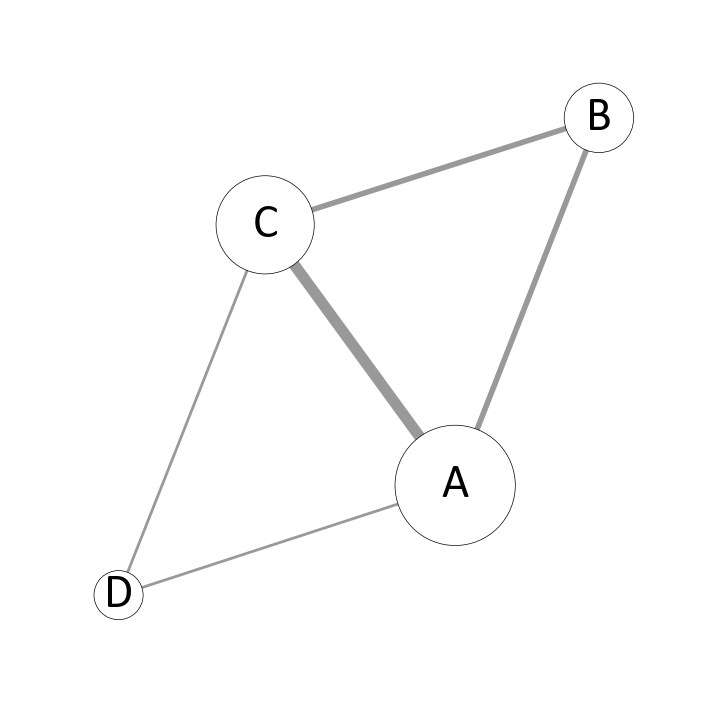

In [13]:
def generate_graph(canvas, selected_groups, num_nodes_to_visualize,padding=0.1):
    
    plt.clf() #clear current figure
    
    
    ### Creates the related components and their connections that will be visualized
    G = nx.Graph() # initialize empty indirected graph
    
    for group in selected_groups:
        add_edges_within_group(G, group)  # Add edges within group
    

    # Count occurrences of each node in selected groups
    node_counts = Counter([node for group in selected_groups for node in group])
    print('node_occurrences', node_counts)
        
   
    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)
    print('sorted_nodes',sorted_nodes)
    
    selected_nodes = sorted_nodes[:num_nodes_to_visualize] # related to slider value
    print('selected_nodes',selected_nodes)
    
    subgraph = G.subgraph(selected_nodes)  # only with selected nodes

    
    
    ### Configure visual properties
    if len(subgraph) < 10:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)
        

    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}  # Store labels for each edge

    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))  # Ensure consistent order for node pair
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"  # Store label for this edge
                edge_occurrences[node_pair] += 1

    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]

    # Print edge widths alongside corresponding node pairs
    for edge, width in zip(subgraph.edges(), edge_widths):
        node_pair = tuple(sorted(edge))
        print(f"Edge {edge_labels[node_pair]}: {width}")

    
    # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())

    if num_nodes_to_visualize > 0:
        node_size_factor = 5000 / num_nodes_to_visualize
    else:
        node_size_factor = 1  # Set a default value to avoid division by zero

    if num_edges > 0:
        edge_width_factor = 10 / num_edges
    else:
        edge_width_factor = 1  # Set a default value to avoid division by zero


    # Normalize node size and edge width
    node_size = [node_counts[n] * node_size_factor for n in subgraph.nodes()]
    edge_widths = [edge_occurrences[tuple(sorted(edge))] * edge_width_factor for edge in subgraph.edges()]

    # Draw nodes and edges with normalized sizes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color="w", edgecolors="k", linewidths=0.5)
    nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
        # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * padding
    ymargin = (ymax - ymin) * padding
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)
    
    nx.draw_networkx_labels(subgraph, pos, labels={node: str(node) for node in subgraph.nodes()}, font_size=50/math.log(num_nodes_to_visualize+1,3), font_family='Calibri', font_weight='normal')

    plt.axis("off")
    canvas.draw()


def on_dropdown_select(event):
    
    global selected_groups
    
    selected_code = dropdown.get()
    
    selected_groups = [group for group in groups if selected_code in group]
    print('selected_groups', selected_groups)
    
    num_nodes_to_visualize = len(set([item for sublist in selected_groups for item in sublist]))
    print('num_nodes_to_visualize', num_nodes_to_visualize)
    slider.config(from_=1, to=num_nodes_to_visualize, tickinterval=num_nodes_to_visualize-1)
    
    generate_graph(canvas, selected_groups, 1)

def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

root = tk.Tk()
root.title("Graph Visualization")

selected_groups = []
dropdown = ttk.Combobox(root, values=options)
dropdown.grid(row=0, column=0, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=lambda x: generate_graph(canvas, selected_groups, int(x)))
slider.grid(row=0, column=1, padx=10, pady=10)


fig = plt.figure(figsize=(9, 9))
#fig.set_facecolor((0.2, 0.2, 0.2))  # RGB values for a darker grey
canvas = FigureCanvasTkAgg(fig, master=root)
#root.attributes('-alpha', 0.8)  # Adjust alpha value as needed (0.0 to 1.0)
root.configure(bg='darkgrey')
canvas.get_tk_widget().grid(row=1, column=0, columnspan=2)

generate_graph(canvas, [], 0)

root.mainloop()



In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add some nodes
G.add_nodes_from([1, 2, 3, 4])

# Add some edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Create a subgraph
subgraph = G.subgraph([1, 2, 3])

# Get the degree of node 1 in the subgraph
degree_of_node_1 = subgraph.degree(1)

print("Degree of node 1 in the subgraph:", degree_of_node_1)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph
G = nx.Graph()

# Add some nodes
G.add_nodes_from([1, 2, 3, 4])

# Add some edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Create a subgraph
subgraph = G.subgraph([1, 2, 3,4])

# Plot the subgraph
nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_color='black')
plt.show()


In [ ]:
subgraph.degree(4)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# Define a function to plot glanzing steel edges with a 3D effect
def plot_glanzing_steel_edges(ax, G, pos, depth=0.1):
    edges = []
    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [depth, depth]
        edges.append(list(zip(x, y, z)))
    for edge in edges:
        ax.plot(*edge, color='silver', linewidth=2)

# Create a graph
G = nx.Graph()

# Add nodes
G.add_nodes_from([1, 2, 3, 4, 5, 6])

# Add edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])

# Specify node positions in 2D space
pos = {1: (1, 1), 2: (2, 2), 3: (3, 3), 4: (4, 4), 5: (5, 5), 6: (6, 6)}

# Draw the graph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Call function to plot glanzing steel edges with a 3D effect
plot_glanzing_steel_edges(ax, G, pos)

# Set axis labels
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Depth', fontsize=12)

# Set title
plt.title('Glanzing Steel Edges', fontsize=14)

# Show the graph
plt.show()
